# A Practical Guide to Running CV Models: ResNet Use Case

This notebook serves as a practical guide to getting started running Computer Vision (CV) models on the E75 and E150 AI accelerator hardware using the TT-BUDA compiler stack.

The tutorial will walk through an example of running the [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) model on Tenstorrent AI accelerator hardware. The model weights will be directly downloaded from the [HuggingFace library](https://huggingface.co/docs/transformers/model_doc/resnet) and executed through the PyBUDA SDK.

**Note on terminology:**

While TT-BUDA is the official Tenstorrent AI/ML compiler stack, PyBUDA is the Python interface for TT-BUDA. TT-BUDA is the core technology; however, PyBUDA allows users to access and utilize TT-BUDA's features directly from Python. This includes directly importing model architectures and weights from PyTorch, TensorFlow, ONNX, and TFLite.

## Guide Overview

In this guide, we will talk through the steps for running the ResNet model trained on [ImageNet](https://www.image-net.org/) data for the **Image Classification** task.

You will learn how to import the appropriate libraries, how to download model weights from popular site such as HuggingFace, utilize the PyBUDA API to initiate an inference experiment, and observe the results from running on Tenstorrent hardware.

## Step 1: Import libraries

Make sure that you have an activate Python environment with the latest version of PyBUDA installed.

In [1]:
# Start by importing the pybuda library, modules from HuggingFace's transformers library, and requests, PIL, & matplotlib libraries for downloading a sample image
import matplotlib.pyplot as plt
import pybuda
import requests
from PIL import Image
from transformers import AutoFeatureExtractor, ResNetForImageClassification

/home/jonathan/Desktop/tenstorrent/tt-buda-demos/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Download the model weights from HuggingFace

In [2]:
# Load ResNet feature extractor and model from HuggingFace
model_ckpt = "microsoft/resnet-50"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = ResNetForImageClassification.from_pretrained(model_ckpt)

/home/jonathan/Desktop/tenstorrent/tt-buda-demos/venv/lib/python3.8/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


## Step 3: Set example input

We will use a real image sample from the web. Let's stream in an image of a tiger from the ImageNet-1k dataset and view the sample.

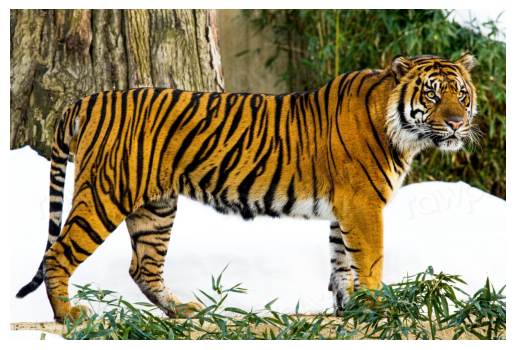

In [3]:
# Load data sample from ImageNet-1k
url = "https://images.rawpixel.com/image_1300/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3BkMTA2LTA0Ny1jaGltXzEuanBn.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# View the image
plt.imshow(image); plt.axis("off");

## Step 4: Data Preprocessing

Data preprocessing is an important step in the AI inference pipeline. For CV models, we apply transformations to the input image such as centering, cropping, padding, resizing, scaling, and normalizing. Some libraries, such as HuggingFace's transformers and PyTorch Image Models (timm), have transform classes to handle this for you.

In [8]:
# Data preprocessing
pixel_values = feature_extractor(image, return_tensors="pt")["pixel_values"]

In [10]:
pixel_values, pixel_values.shape

(tensor([[[[-0.3712, -0.4397,  0.6392,  ..., -1.0733, -1.4843, -1.3302],
           [-0.9020, -0.4226,  0.5193,  ..., -0.7137, -0.8335, -1.0219],
           [-1.1589, -0.7308, -0.1486,  ..., -0.1486, -0.1999, -0.9534],
           ...,
           [ 0.4337,  0.3994, -0.2342,  ..., -1.0219, -0.4054, -0.4054],
           [-1.1075, -0.1828, -1.0048,  ...,  0.6049,  1.0331,  1.3584],
           [-1.1589, -0.6794, -0.3198,  ...,  0.3138,  2.0092,  2.1290]],
 
          [[-0.4426, -0.3725,  0.6954,  ..., -0.2675, -0.6176, -0.7052],
           [-0.8803, -0.3725,  0.5553,  ..., -0.0924,  0.0126, -0.2325],
           [-1.1779, -0.6702, -0.1625,  ...,  0.1702,  0.4328, -0.2850],
           ...,
           [ 1.0630,  0.8880,  0.2752,  ..., -0.8627, -0.5126, -0.5301],
           [-0.2850,  0.4328, -0.4601,  ...,  0.3978,  0.6604,  1.0455],
           [-0.3200,  0.0651,  0.2227,  ...,  0.4153,  1.8859,  2.0609]],
 
          [[-0.7413, -0.7413,  0.1999,  ..., -1.0898, -1.3687, -1.3861],
           [-

## Step 5: Configure PyBUDA Parameters

There are optional configurations that can be adjusted before compiling and running a model on Tenstorrent hardware. Sometimes, the configurations are necessary to compile the model and other times they are tuneable parameters that can be adjusted for performance enhancement.

For the ResNet model, two key parameters are required for compilation:

* `balancer_policy`
* `enable_t_streaming`

In [5]:
# Set PyBUDA configuration parameters
compiler_cfg = pybuda.config._get_global_compiler_config()  # get global configuration object
compiler_cfg.balancer_policy = "Ribbon"  # set balancer policy
compiler_cfg.enable_t_streaming = True  # enable tensor streaming

## Step 6: Instantiate Tenstorrent device

The first time we use PyBUDA, we must initialize a `TTDevice` object which serves as the abstraction over the target hardware.

In [6]:
tt0 = pybuda.TTDevice(
    name="tt_device_0",  # here we can give our device any name we wish, for tracking purposes
    arch=pybuda.BackendDevice.Grayskull  # we set the target device architecture to compile for
)

## Step 7: Create a PyBUDA module from PyTorch model

Next, we must abstract the PyTorch model loaded from HuggingFace into a `pybuda.PyTorchModule` object. This will let the BUDA compiler know which model architecture and AI framework it has to compile.

We then "place" this module onto the previously initialized `TTDevice`.

In [7]:
# Create module
pybuda_module = pybuda.PyTorchModule(
    name = "pt_resnet50",  # give the module a name, this will be used for tracking purposes
    module=model  # specify the model that is being targeted for compilation
)

# Place module on device
tt0.place_module(module=pybuda_module)

## Step 8: Push the inputs into the model input queue

In [11]:
# Push inputs
tt0.push_to_inputs((pixel_values,))

## Step 9: Run inference on the targeted device

Running a model on a Tenstorrent device invovles two parts: compilation and runtime.

Compilation -- TT-BUDA is a compiler. Meaning that it will take a model architecture graph and compile it for the target hardware. Compilation can take anywhere from a few seconds to a few minutes, depending on the model. This only needs to happen once. When you execute the following block of code the compilation logs will be displayed.

Runtime -- once the model has been compiled and loaded onto the device, the user can push new inputs which will execute immediately.

The `run_inference` API can achieve both steps in a single call. If it's the first call, the model will compile. Any subsequent calls will execute runtime only.

Please refer to the documentation for alternative APIs such as `initialize_pipeline` and `run_forward`.

In [12]:
# Run inference on Tenstorrent device
output_q = pybuda.run_inference()  # executes compilation (if first time) + runtime
output = output_q.get()  # get last value from output queue

2024-03-06 14:25:54.665 | INFO     | Always          - initialize_child_process called on pid 563238


/home/jonathan/Desktop/tenstorrent/tt-buda-demos/venv/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/jonathan/Desktop/tenstorrent/tt-buda-demos/venv/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/jonathan/Desktop/tenstorrent/tt-buda-demos/venv/lib/python3.8/site-packages/transformers/models/resnet/modeling_resnet.py:95: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to

2024-03-06 14:26:10.424 | INFO     | Always          - initialize_child_process called on pid 564203
2024-03-06 14:26:10.441 | INFO     | SiliconDriver   - Detected 1 PCI device
2024-03-06 14:26:10.466 | INFO     | SiliconDriver   - Using 1 Hugepages/NumHostMemChannels for TTDevice (pci_interface_id: 0 device_id: 0xfaca revision: 0)


2024-03-06 14:26:10.728 | INFO     | pybuda.compile:pybuda_compile:319 - Running post initial graph pass
2024-03-06 14:26:13.003 | INFO     | pybuda.compile:pybuda_compile:391 - Running post autograd graph pass
2024-03-06 14:26:13.057 | INFO     | pybuda.compile:pybuda_compile:424 - Lowering to Buda


2024-03-06 14:26:18.470 | INFO     | GraphCompiler   - Running with Automatic Mixed Precision Level = 0.
2024-03-06 14:26:18.494 | INFO     | Always          - Running Balancer with Policy: PolicyType::Ribbon
2024-03-06 14:26:23.645 | INFO     | Balancer        - Starting Ribbon balancing.
2024-03-06 14:26:26.998 | INFO     | Balancer        - Balancing 39% complete.
2024-03-06 14:26:27.682 | INFO     | Balancer        - Balancing 65% complete.
2024-03-06 14:26:28.503 | INFO     | Balancer        - Balancing 84% complete.
2024-03-06 14:26:28.828 | INFO     | Balancer        - Balancing 98% complete.
2024-03-06 14:26:28.829 | INFO     | Balancer        - Balancing 100% completed!
2024-03-06 14:26:29.111 | WARNING  | Placer          - Compilation Option with input queue placed on host, but Grayskull does not support fast device reads from host. Placer opting to allocate the queue on device instead.
2024-03-06 14:26:29.117 | INFO     | Always          - Lookup contexts -- arch:system scop

2024-03-06 14:26:29.303 | INFO     | pybuda.compile:pybuda_compile:626 - Generating Netlist
2024-03-06 14:26:29.441 | INFO     | pybuda.ci:create_symlink:85 - Symlink created from /home/jonathan/Desktop/tenstorrent/tt-buda-demos/first_5_steps/pt_resnet50_netlist.yaml to /tmp/jonathan/bb364876082a/pt_resnet50_netlist.yaml
2024-03-06 14:26:30.384 | DEBUG    | pybuda.tensor:consteval_tensor:1177 - ConstEval graph: input_1_add_1_fork_clone1120
2024-03-06 14:26:30.385 | DEBUG    | pybuda.tensor:consteval_tensor:1177 - ConstEval graph: input_1_add_16_fork_clone1163
2024-03-06 14:26:30.386 | DEBUG    | pybuda.tensor:consteval_tensor:1177 - ConstEval graph: input_1_add_30_fork_clone1095
2024-03-06 14:26:30.387 | DEBUG    | pybuda.tensor:consteval_tensor:1177 - ConstEval graph: input_1_add_44_fork_clone1005
2024-03-06 14:26:30.387 | DEBUG    | pybuda.tensor:consteval_tensor:1177 - ConstEval graph: input_1_add_57_fork_clone1010
2024-03-06 14:26:30.388 | DEBUG    | pybuda.tensor:consteval_tensor:

2024-03-06 14:26:30.513 | INFO     | Always          - Running tt_runtime on host: 'benderv2'
2024-03-06 14:26:30.513 | INFO     | PerfInfra       - Backend profiler is disabled
2024-03-06 14:26:30.513 | INFO     | Netlist         - Parsing Netlist from file: /tmp/jonathan/bb364876082a/pt_resnet50_netlist.yaml
2024-03-06 14:26:30.623 | INFO     | SiliconDriver   - Detected 1 PCI device
2024-03-06 14:26:30.624 | INFO     | SiliconDriver   - Using 1 Hugepages/NumHostMemChannels for TTDevice (pci_interface_id: 0 device_id: 0xfaca revision: 0)
2024-03-06 14:26:30.722 | INFO     | Always          - Using Default BRISC Bin
2024-03-06 14:26:30.722 | INFO     | CompileTrisc    - Compiling NCRISC firmware
2024-03-06 14:26:32.855 | INFO     | CompileTrisc    - Compiling TRISC kernels
2024-03-06 14:26:32.858 | INFO     | Net2Hlks        - Parsing fused ops..
2024-03-06 14:26:47.867 | INFO     | CompileTrisc    - Compiling TRISC kernels, Done!
2024-03-06 14:26:47.869 | INFO     | Loader          -

2024-03-06 14:26:48.381 | INFO     | pybuda.backend:feeder_thread_main:120 - Feeder thread on <pybuda.backend.BackendAPI object at 0x7f162bf2fe20> starting
2024-03-06 14:26:48.381 | DEBUG    | pybuda.backend:push_constants_and_parameters:435 - Pushing to constant lc.input_tensor.conv2d_0.dc.conv2d.3.dc.conv2d.1.dc.sparse_matmul.9.dc.sparse_matmul.1.0
2024-03-06 14:26:48.381 | DEBUG    | pybuda.backend:push_constants_and_parameters:435 - Pushing to constant lc.input_tensor.conv2d_0.dc.conv2d.3.dc.conv2d.1.dc.sparse_matmul.9.dc.sparse_matmul.1.1
2024-03-06 14:26:48.382 | DEBUG    | pybuda.backend:push_constants_and_parameters:435 - Pushing to constant lc.input_tensor.conv2d_0.dc.conv2d.3.dc.conv2d.3.dc.sparse_matmul.9.dc.sparse_matmul.1.0
2024-03-06 14:26:48.382 | DEBUG    | pybuda.backend:push_constants_and_parameters:435 - Pushing to constant lc.input_tensor.conv2d_0.dc.conv2d.3.dc.conv2d.3.dc.sparse_matmul.9.dc.sparse_matmul.1.1
2024-03-06 14:26:48.382 | DEBUG    | pybuda.backend:push

2024-03-06 14:26:48.454 | INFO     | Netlist         - Parsing Netlist from file: /tmp/jonathan/bb364876082a/pt_resnet50_netlist.yaml
2024-03-06 14:26:48.541 | INFO     | SiliconDriver   - Detected 1 PCI device
2024-03-06 14:26:48.566 | INFO     | SiliconDriver   - Using 1 Hugepages/NumHostMemChannels for TTDevice (pci_interface_id: 0 device_id: 0xfaca revision: 0)
2024-03-06 14:26:48.581 | INFO     | SiliconDriver   - Disable PCIE DMA
2024-03-06 14:26:48.586 | INFO     | Runtime         - Running program 'run_fwd_0' with params [("$p_loop_count", "1")]
2024-03-06 14:26:48.587 | INFO     | IO              - Initializing Shuffler for Convolution


2024-03-06 14:26:48.585 | DEBUG    | pybuda.device:run_next_command:426 - Received RUN_FORWARD command on TTDevice 'tt_device_0' / 564203
2024-03-06 14:26:48.585 | DEBUG    | pybuda.ttdevice:forward:862 - Starting forward on TTDevice 'tt_device_0'
2024-03-06 14:26:48.586 | DEBUG    | pybuda.backend:read_queues:316 - Reading output queue pt_resnet50.output_add_759
2024-03-06 14:26:48.586 | DEBUG    | pybuda.backend:feeder_thread_main:142 - Run feeder thread cmd: fwd
2024-03-06 14:26:48.587 | DEBUG    | pybuda.device_connector:pusher_thread_main:159 - Pusher thread pushing tensors
2024-03-06 14:26:48.587 | DEBUG    | pybuda.backend:push_to_queues:407 - Pushing to queue pixel_values
2024-03-06 14:26:48.596 | DEBUG    | pybuda.backend:read_queues:376 - Done reading queues
2024-03-06 14:26:48.597 | DEBUG    | pybuda.backend:pop_queues:382 - Popping from queue pt_resnet50.output_add_759


## Step 10: Data Postprocessing

Data postprocessing is done to convert the model outputs into a readable / useful format. For image classification tasks, this usually means receiving the logit outputs from the model, extracting the top predicted class, and matching this with an entry from the label dictionary.

In [13]:
# Data postprocessing
predicted_value = output[0].value().argmax(-1).item()
predicted_label = model.config.id2label[predicted_value]

## Step 11: Print and evaluate outputs

In [14]:
# Print outputs
print(f"Predicted_label: {predicted_label}")

Predicted_label: tiger, Panthera tigris


## Step 12: Shutdown PyBuda

In [ ]:
pybuda.shutdown()